#### Machine Learning

**XG Boost**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
df_airlines = pd.read_csv('../data/ontime_2025.csv')
df_airlines.head(5)

,year,month,day_of_month,day_of_week,op_unique_carrier,op_carrier_airline_id,op_carrier_fl_num,origin,origin_city_name,origin_state_abr,...,carrier_delay,weather_delay,nas_delay,security_delay,dep_time_dt,arr_time_dt,dep_bin,season,delay_category,fl_date
0,2024,11,1,5,9E,20363,4800,CLT,"Charlotte, NC",NC,...,6.0,0.0,0.0,0.0,1900-01-01 18:28:00,1900-01-01 20:15:00,Early Evening,Autumn,Moderate Delay,2024-11-01
1,2024,11,1,5,9E,20363,4801,CVG,"Cincinnati, OH",KY,...,0.0,0.0,0.0,0.0,1900-01-01 17:41:00,1900-01-01 18:49:00,Afternoon,Autumn,On Time,2024-11-01
2,2024,11,1,5,9E,20363,4802,DSM,"Des Moines, IA",IA,...,0.0,0.0,0.0,0.0,1900-01-01 15:54:00,1900-01-01 16:57:00,Afternoon,Autumn,On Time,2024-11-01
3,2024,11,1,5,9E,20363,4803,CVG,"Cincinnati, OH",KY,...,0.0,0.0,0.0,0.0,1900-01-01 13:50:00,1900-01-01 14:55:00,Midday,Autumn,On Time,2024-11-01
4,2024,11,1,5,9E,20363,4804,GSP,"Greer, SC",SC,...,0.0,0.0,0.0,0.0,1900-01-01 12:45:00,1900-01-01 14:35:00,Midday,Autumn,On Time,2024-11-01


In [3]:
df_airlines['is_delayed'] = df_airlines['dep_del15']

In [4]:
df_ml = df_airlines[df_airlines['cancelled'] == 0].copy()

In [ ]:
df_ml_numeric = df_ml[['month', 'day_of_month', 'day_of_week']]

df_ml_cat = df_ml[
    [
        'dep_bin',
        'season',
        'origin',
        'dest',
        'op_unique_carrier'
    ]
]

*Scale*

In [ ]:
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, df_ml_numeric.columns)
    ]
)

ml_numeric_scaled = preprocessor.fit_transform(df_ml_numeric)

df_ml_numeric_scaled = pd.DataFrame(
    ml_numeric_scaled,
    columns=df_ml_numeric.columns,
    index=df_ml_numeric.index
)

In [ ]:
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, df_ml_cat.columns)
    ]
)

ml_cat_scaled = preprocessor.fit_transform(df_ml_cat)

feature_names = preprocessor.get_feature_names_out()

df_ml_cat_scaled = pd.DataFrame(
    ml_cat_scaled.toarray() if hasattr(ml_cat_scaled, "toarray") else ml_cat_scaled,
    columns=feature_names,
    index=df_ml_cat.index
)

In [ ]:
df_ml_concat = pd.concat([df_ml_numeric_scaled, df_ml_cat_scaled], axis=1)

In [5]:
features = [
    'month',
    'day_of_month',
    'day_of_week',
    'dep_bin',
    'season',
    'origin',
    'dest',
    'op_unique_carrier'
]

target = 'is_delayed'

X = df_ml[features]
y = df_ml[target]

#### XG Boost Model

In [13]:
from xgboost import XGBClassifier

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        n_estimators=20,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        eval_metric='logloss',
        random_state=42
    ))
])

*Split into Training and Testing sets*

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

*Fit the model*

In [14]:
xgb_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

*Predict and Evaluate*

In [15]:
y_pred_xgb = xgb_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.88      0.60      0.72   1095914
         1.0       0.32      0.70      0.44    289744

    accuracy                           0.62   1385658
   macro avg       0.60      0.65      0.58   1385658
weighted avg       0.76      0.62      0.66   1385658



*Visualize the performance*

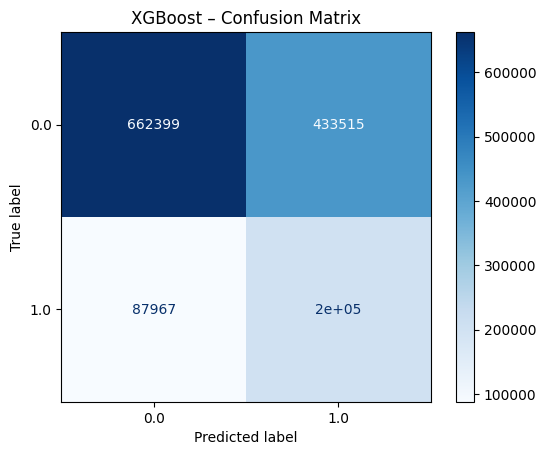

In [16]:
ConfusionMatrixDisplay.from_estimator(
    xgb_pipeline,
    X_test,
    y_test,
    cmap='Blues'
)
plt.title('XGBoost – Confusion Matrix')
plt.show()

In [17]:
import joblib

joblib.dump(xgb_pipeline, "xgb_model.pkl")

['xgb_model.pkl']

#### Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

over_sampling = RandomOverSampler(random_state=42)
X_over, y_over = over_sampling.fit_resample(X_train, y_train)

xg_boost_over = XGBClassifier(
        n_estimators=20,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        eval_metric='logloss',
        random_state=42
    ).fit(X_over, y_over)
print(f"Oversampling Recall: {recall_score(y_test, lr_over.predict(X_test))}")

#### Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

uner_sampling = RandomUnderSampler(random_state=42)
X_under, y_under = uner_sampling.fit_resample(X_train, y_train)

xg_boost_under = XGBClassifier(
        n_estimators=20,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        eval_metric='logloss',
        random_state=42
    ).fit(X_under, y_under)
print(f"Undersampling Recall: {recall_score(y_test, lr_under.predict(X_test))}")

### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

xg_boost_smote = XGBClassifier(
        n_estimators=20,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        eval_metric='logloss',
        random_state=42
    ).fit(X_smote, y_smote)
print(f"SMOTE Recall: {recall_score(y_test, lr_smote.predict(X_test))}")